<a href="https://colab.research.google.com/github/nelslindahlx/Data-Analysis/blob/master/TimelineofQuantumComputingMilestones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Timeline of Quantum Computing Milestones (1990–2045)

This visualization shows the progression of key quantum computing milestones on a horizontal timeline.  
Historical events are displayed as filled circles, while speculative forward-looking events are shown as hollow circles with dashed connectors.

### Features
- **Data model**: Each milestone is stored as a tuple `(year, "Event", "Category", speculative_flag)`.
- **Visual encoding**:
  - Historical events → filled markers.
  - Speculative milestones → hollow markers with dashed Bézier connectors.
- **Non-overlap layout**: Labels are positioned using a greedy placement algorithm that alternates sides and tiers to avoid collisions.
- **Context bands**: Shaded footer separates two eras:
  - *NISQ and Early Quantum Utility* (1990–2025)
  - *Toward Fault-Tolerant Era* (2025–2045)
- **Legend**: Centered at the bottom, grouped by milestone category.

### How to extend
- Add new milestones by appending to the `events` list.
- Update or add categories in the `category_colors` dictionary.
- Adjust spacing by changing `base_offset` in the `build_layout` function.
- Modify the `eras` list to redefine shaded background bands.

### Things to consider
- Favor **credible sources** (papers, benchmarks, vendor docs) for historical entries.
- Avoid using raw qubit counts alone; include **error rates and logical qubit thresholds** for meaningful milestones.
- Split broad categories like "Applications" into chemistry, materials, optimization, or cryptanalysis for clarity.
- Keep speculative entries tied to measurable, falsifiable targets.

---


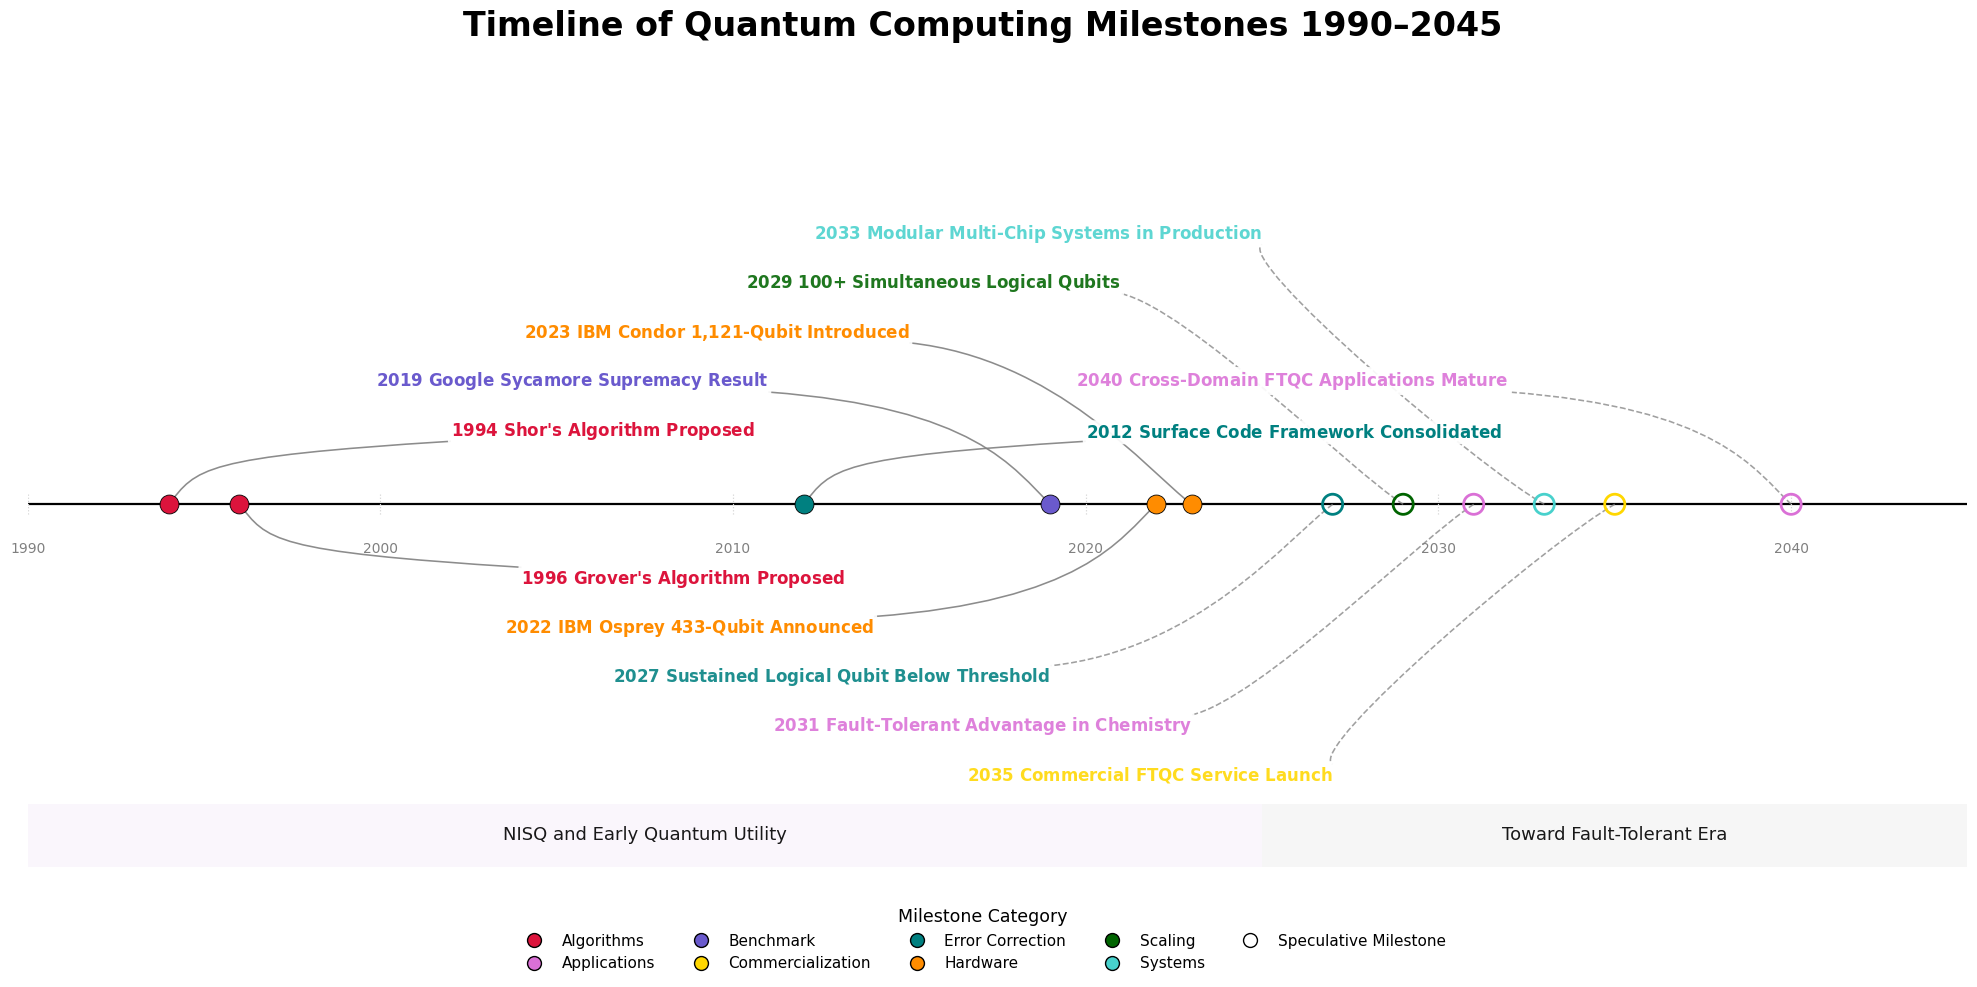

In [2]:
# Timeline of Quantum Computing Milestones 1990–2045
# With Bézier connectors, non-overlap, adjusted title spacing, taller footer, and centered legend

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# Data: (year, "Milestone", "Category", SpeculativeFlag)
events = [
    # Historical
    (1994, "Shor's Algorithm Proposed", "Algorithms", False),
    (1996, "Grover's Algorithm Proposed", "Algorithms", False),
    (2012, "Surface Code Framework Consolidated", "Error Correction", False),
    (2019, "Google Sycamore Supremacy Result", "Benchmark", False),
    (2022, "IBM Osprey 433-Qubit Announced", "Hardware", False),
    (2023, "IBM Condor 1,121-Qubit Introduced", "Hardware", False),

    # Speculative forward milestones
    (2027, "Sustained Logical Qubit Below Threshold", "Error Correction", True),
    (2029, "100+ Simultaneous Logical Qubits", "Scaling", True),
    (2031, "Fault-Tolerant Advantage in Chemistry", "Applications", True),
    (2033, "Modular Multi-Chip Systems in Production", "Systems", True),
    (2035, "Commercial FTQC Service Launch", "Commercialization", True),
    (2040, "Cross-Domain FTQC Applications Mature", "Applications", True),
]

# Category color palette
category_colors = {
    "Algorithms": "crimson",
    "Error Correction": "teal",
    "Benchmark": "slateblue",
    "Hardware": "darkorange",
    "Scaling": "darkgreen",
    "Applications": "orchid",
    "Systems": "mediumturquoise",
    "Commercialization": "gold",
}

# Eras for footer band
eras = [
    (1990, 2025, "NISQ and Early Quantum Utility", "#efe1f7"),
    (2025, 2045, "Toward Fault-Tolerant Era", "#e0e0e0"),
]

# Helpers
def fmt_label(year, text):
    return rf"$\bf{{{year}}}$ {text}"

def label_width_units(s):
    # Rough width estimator in data units to reduce overlap
    return max(8.5, 0.36 * len(s))

def tier_levels(n_above=7):
    # Symmetric label tiers above and below the axis
    above = [1.6 + i * 1.25 for i in range(n_above)]
    below = [-v for v in above]
    return above, below

def bezier_connector(ax, x0, y0, x1, y1, side, tier_index, future=False):
    # Curved connector from year marker to off-axis label
    lift = 0.9
    fan_x = 1.6 + 0.6 * tier_index
    c1 = (x0 + side * (0.8 + 0.25 * tier_index), y0 + np.sign(y1) * lift)
    c2 = (x0 + side * fan_x * abs(y1) / 3.0, y1 - np.sign(y1) * 0.4)
    verts = [(x0, y0), c1, c2, (x1, y1)]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    patch = PathPatch(
        Path(verts, codes),
        facecolor="none",
        edgecolor="gray",
        lw=1.15,
        alpha=0.75 if future else 0.9,
        linestyle="dashed" if future else "solid",
        zorder=2,
    )
    ax.add_patch(patch)

def build_layout(events, xmin, xmax, base_offset=8.0):
    # Greedy placement that alternates sides and climbs tiers to avoid overlap
    items = sorted(events, key=lambda x: (x[0], x[1]))
    tiers_above, tiers_below = tier_levels()
    state_above = [{"xr": -1e9} for _ in tiers_above]
    state_below = [{"xr": -1e9} for _ in tiers_below]
    placements = []
    min_gap = 0.9
    max_offset = 15.0

    for idx, (year, text, cat, future) in enumerate(items):
        label_txt = fmt_label(year, text)
        w = label_width_units(label_txt)
        prefer_side = 1 if idx % 2 == 0 else -1
        offset = base_offset
        placed = False
        while not placed and offset <= max_offset:
            for side, tiers, state in [(prefer_side, tiers_above, state_above),
                                       (-prefer_side, tiers_below, state_below)]:
                for t_idx, ty in enumerate(tiers):
                    x_anchor = year + side * offset
                    xl, xr = (x_anchor, x_anchor + w) if side > 0 else (x_anchor - w, x_anchor)
                    if xl <= state[t_idx]["xr"] + min_gap:
                        continue
                    if xl < xmin + 1.2 or xr > xmax - 1.2:
                        continue
                    state[t_idx]["xr"] = xr
                    placements.append({
                        "year": year, "text": label_txt, "cat": cat, "future": future,
                        "x_label": x_anchor, "y_label": ty, "side": side, "tier_idx": t_idx
                    })
                    placed = True
                    break
                if placed:
                    break
            offset += 0.8
    return placements

# Plot frame
min_year, max_year = 1990, 2045
fig, ax = plt.subplots(figsize=(20, 10))
ax.hlines(0, min_year, max_year, color="black", lw=1.6)

# Era footer band
footer_y, footer_h = -9.2, 1.6
for s, e, name, col in eras:
    ax.fill_between([s, e], [footer_y], [footer_y + footer_h], color=col, alpha=0.28, lw=0)
    ax.text((s + e) / 2, footer_y + footer_h * 0.5, name, ha="center", va="center",
            fontsize=13, color="black", alpha=0.9)

# Decade ticks
for d in [1990, 2000, 2010, 2020, 2030, 2040]:
    ax.vlines(d, -0.25, 0.25, colors="lightgray", linestyles="dotted", linewidth=0.85)
    ax.text(d, -0.95, str(d), ha="center", va="top", fontsize=10, color="gray")

# Year markers
for y, t, c, f in events:
    if f:
        ax.scatter(y, 0, s=210, facecolors="none",
                   edgecolors=category_colors.get(c, "black"),
                   linewidth=2.0, zorder=3)
    else:
        ax.scatter(y, 0, s=185,
                   color=category_colors.get(c, "black"),
                   edgecolors="black", linewidth=0.6, zorder=3)

# Label layout and connectors
placements = build_layout(events, xmin=min_year, xmax=max_year, base_offset=8.0)
for p in placements:
    bezier_connector(ax, p["year"], 0, p["x_label"], p["y_label"],
                     p["side"], p["tier_idx"], future=p["future"])
    ax.text(p["x_label"], p["y_label"], p["text"],
            ha="left" if p["side"] > 0 else "right",
            va="bottom" if p["y_label"] > 0 else "top",
            fontsize=12, fontweight="semibold",
            color=category_colors.get(p["cat"], "black"),
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.92),
            alpha=0.88 if p["future"] else 1.0, zorder=4)

# Centered legend
handles = [plt.Line2D([0], [0], marker="o", color="w", label=cat,
                      markerfacecolor=category_colors[cat],
                      markeredgecolor="black", markersize=10)
           for cat in sorted({c for _, _, c, _ in events})]
handles.append(plt.Line2D([0], [0], marker="o", color="w", label="Speculative Milestone",
                          markerfacecolor="none", markeredgecolor="black", linestyle="dashed", markersize=10))
fig.legend(handles=handles, title="Milestone Category",
           loc="lower center", ncol=5, fontsize=11, title_fontsize=12.5, frameon=False, bbox_to_anchor=(0.5, 0.02))

# Title and layout
fig.suptitle("Timeline of Quantum Computing Milestones 1990–2045",
             fontsize=24, fontweight="bold", y=0.995)
plt.tight_layout(rect=[0, 0.06, 1, 0.965])

ax.axis("off")
ax.set_xlim(min_year, max_year)
ax.set_ylim(-10.2, 10.2)
plt.show()
